# Compare Sampling Strategies using an MBTR Forcefield
Here, we hold our learning strategy constant and vary the strategies used in sampling

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.compare import compare_hessians
from ase.vibrations import VibrationsData
from scipy.interpolate import interp1d
from dataclasses import asdict
from pathlib import Path
from ase.io import read
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import re

Configuration

In [2]:
target_result = '../0_create-test-set/data/exact/caffeine_pm7_None_at_pm7_None_d=0.01-ase.json'
target_method = '../2_testing-fitting-strategies/data/mbtr/'
target_size: int = 1500

Derived

In [3]:
mol_name, _ = Path(target_result).name.rsplit("_", 1)

## Load the Exact Result
The target molecule filename determines which molecule we'll look for. The name includes both the molecule name and method used to evaluate the hessian

In [4]:
exact_hess = VibrationsData.read(target_result)
exact_hess

## Find All Fittings
Find the approximate hessians produced using each method

In [5]:
all_hessians = list(Path(target_method).glob(f"{mol_name}_*-increment.json"))
print(f'Found {len(all_hessians)} approximate Hessians')

Found 11 approximate Hessians


In [6]:
def load_hessian(path: Path) -> list[dict[str, object], str]:
    """Load the Hessian and parse the metadata from the filename
    
    Args:
        path: Path to the run path
    Returns:
        Dictionary the includes the metadata:
    """
    
    # Get some of the basic information
    _, sampling_method, sampling_options_str = path.name[:-15].rsplit("_", 2)
    try:
        if sampling_options_str.count("=") == 1:
            sampling_options = dict([sampling_options_str.split("=")])
        else:
            sampling_options = dict(x.split("=") for x in re.split("-([^\d]+=.+?)-", sampling_options_str + "-") if len(x) > 0)
    except ValueError as e:
        raise ValueError(f'Failure for {sampling_options_str}') from e
    
    # For each, load the Hessian on the full dataset and compare to exact answer
    output = []
    with path.open() as fp:
        for line in fp:
            record = json.loads(line)
            compare = compare_hessians(exact_hess.get_atoms(), exact_hess.get_hessian_2d(), record['hessian'])
            output.append({
                'path': path,
                'sampling_method': sampling_method,
                'options': sampling_options_str,
                'size': record['count'],
                **sampling_options,
                **asdict(compare)
            })      
    return output
all_results = pd.DataFrame(sum([load_hessian(path) for path in tqdm(all_hessians)], []))
print(f'Loaded {len(all_results)} approximate hessians')

  0%|                                                                                                                                                                                                                                                              | 0/11 [00:00<?, ?it/s]/home/lward/miniconda3/envs/jitterbug/lib/python3.9/site-packages/pmutt/statmech/vib.py:87: RuntimeWarning: overflow encountered in sinh
  (0.5 * vib_dimless)**2 * (1. / np.sinh(vib_dimless / 2.))**2
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.80it/s]

Loaded 176 approximate hessians


In [7]:
all_results.iloc[0]

path               ../2_testing-fitting-strategies/data/mbtr/caff...
sampling_method                                           along-axes
options                                               d=2.00e-02-N=2
size                                                               5
d                                                           2.00e-02
N                                                                  2
scale_factor                                                     1.0
zpe                                                         5.058148
zpe_error                                                -104.407702
cp                 [0.014146793803042134, 0.01771395512622287, 0....
cp_error           [-0.010065824804868617, -0.01212553988407947, ...
h                  [5.072098696119492, 5.11863818857305, 5.175908...
h_error            [104.39707523324437, 104.36530161384731, 104.3...
temps              [1.0, 3.9291338582677167, 6.858267716535433, 9...
vib_freqs          [0.0, 0.0, 0.0,

Coerce columns I know should be numeric

In [8]:
for col in ['d', 'N']:
    all_results[col] = pd.to_numeric(all_results[col])

In [9]:
all_results.drop_duplicates('path')['sampling_method'].value_counts()

along-vibrational-modes     6
along-axes                  3
random-dir-same-dist        1
random-dir-variable-dist    1
Name: sampling_method, dtype: int64

## Compute Performance Metrics
Get things like the error in ZPE or vibrational frequencies

## Find the Best Method for Each Sampling Strategy
Interpolate performance at 1500 entries

In [10]:
def evaluate_group(group: pd.DataFrame) -> float:
    """Estimate performance at 1500 data points using interpolation"""
    
    return interp1d(group['size'], group['vib_mae'], fill_value=group['vib_mae'].max(), bounds_error=False)(target_size)

In [11]:
best_for_sampling_method = set(all_results.groupby(['path', 'sampling_method']).apply(evaluate_group).groupby('sampling_method').apply(lambda x: x.index[np.argmin(x)][0]))

In [12]:
best_for_sampling_method

{PosixPath('../2_testing-fitting-strategies/data/mbtr/caffeine_pm7_None_at_pm7_None_along-axes_d=2.00e-02-N=4-increment.json'),
 PosixPath('../2_testing-fitting-strategies/data/mbtr/caffeine_pm7_None_at_pm7_None_along-vibrational-modes_d=1.00e-03-N=32-maxstep=6.00e-02-lower=xtb+None-increment.json'),
 PosixPath('../2_testing-fitting-strategies/data/mbtr/caffeine_pm7_None_at_pm7_None_random-dir-same-dist_d=2.00e-02-increment.json'),
 PosixPath('../2_testing-fitting-strategies/data/mbtr/caffeine_pm7_None_at_pm7_None_random-dir-variable-dist_d=2.00e-02-increment.json')}

Plot the best for each sampling methods

In [13]:
subset = all_results[all_results['path'].apply(best_for_sampling_method.__contains__)]

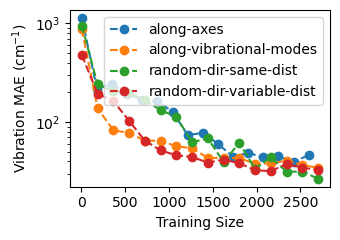

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for gid, group in subset.groupby('sampling_method'):
    ax.plot(group['size'], group['vib_mae'], '--o', label=gid)
    
ax.legend()

ax.set_yscale('log')

ax.set_xlabel('Training Size')
ax.set_ylabel('Vibration MAE (cm$^{-1}$)')

fig.tight_layout()

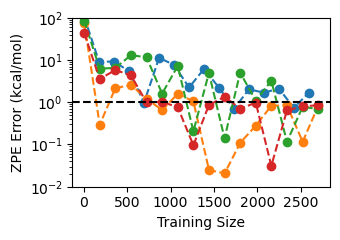

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for gid, group in subset.groupby('sampling_method'):
    ax.plot(group['size'], group['zpe_error'].abs(), '--o', label=gid)
    
#ax.legend()

ax.set_yscale('log')
ax.set_ylim(1e-2, 100)

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1, 1], 'k--')

ax.set_xlabel('Training Size')
ax.set_ylabel('ZPE Error (kcal/mol)')

fig.tight_layout()

It seems like random sampling is preferred, and it is especially stable if we sample random directions

## Explore Effect of Sampling Size
What is the best magnitude?

In [16]:
best_strategy = all_results.query('sampling_method=="random-dir-variable-dist"')

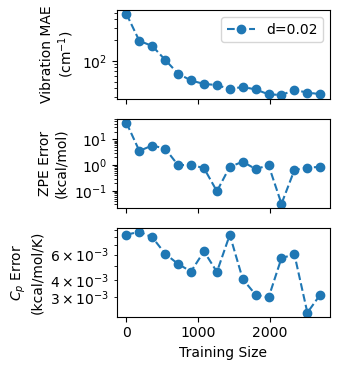

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 3.8), sharex=True)

for gid, group in best_strategy.groupby('d'):
    axs[0].plot(group['size'], group['vib_mae'], '--o', label=f'd={gid}')
    axs[1].plot(group['size'], group['zpe_error'].abs(), '--o', label=f'd={gid}')
    axs[2].plot(group['size'], group['cp_error'].apply(np.array).apply(np.abs).apply(np.mean), '--o', label=f'd={gid}')
    
    
# Labels
axs[0].legend()
axs[0].set_ylabel('Vibration MAE\n(cm$^{-1}$)')
axs[1].set_ylabel('ZPE Error\n(kcal/mol)')
axs[2].set_ylabel('$C_p$ Error\n(kcal/mol/K)')

for ax in axs:
    ax.set_yscale('log')

axs[-1].set_xlabel('Training Size')

fig.tight_layout()

Evaluate the enthalpy differences

In [18]:
best_model = best_strategy.query('d==0.01').sort_values('size').tail().iloc[0]

IndexError: single positional indexer is out-of-bounds

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(best_model['temps'], best_model['h'], 'r', label='Approx')
ax.plot(best_model['temps'], np.add(best_model['h'], best_model['h_error']), '--k', label='True')

ax.legend()
ax.set_xlabel('Temp (K)')
ax.set_ylabel('$H$ (kcal/mol)')